# TFIDF V1

The goal of this notebook is to load data from multiple locations and compare their performance / validate.

In [1]:
import os
from datetime import datetime
import sys

sys.path.append("../scripts/twitter")
from searchTwitter import TwitterDataFrame

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
import emoji
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

np.random.seed(23)

# Set up sns
sns.set(rc = {'figure.figsize':(10,10)})
sns.set_style("whitegrid")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Reads files in a directory as csv and returns dataframe
def concat_data(base_dir):
    files = os.listdir(base_dir)
    dfs = []
    for f in files:
        if ".csv" in f:
            dfs.append(pd.read_csv(base_dir + f))
        
    return pd.concat(dfs)

In [3]:
dfs = []
cities = ["phoenix", "portland", "san_francisco", "seattle"]
for city in cities:
    df = concat_data("../data/{}/".format(city))
    df['city'] = city
    dfs.append(df)
    
# Turn into a TwitterDataFrame
df_raw = TwitterDataFrame(pd.concat(dfs))
df_raw.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_16380/1943339143.py:7: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(base_dir + f))


,id,author_id,text,geo,created_at,lat,lon,city
0,1024082187115622400,1708905816,Time for Monday Night Raw! #RAW,{'place_id': '5c62ffb0f0f3479d'},2018-07-30 23:59:54,33.290260,-112.323914,phoenix
1,1024082144958636037,795028712408293376,@14bigjay88 @tate_slade_obsf they aren't gonna...,{'place_id': '0015d9147cee6907'},2018-07-30 23:59:44,33.384785,-112.357999,phoenix
2,1024082071222808577,275357706,@NicoleBarbaro Thanks for sharing! My younger ...,{'place_id': '7cb7440bcf83d464'},2018-07-30 23:59:26,33.319945,-111.979047,phoenix
3,1024082016969486337,20756054,@Telegraph I like all the people who are too b...,{'place_id': '5c62ffb0f0f3479d'},2018-07-30 23:59:14,33.290260,-112.323914,phoenix
4,1024081978864193536,601192710,"Adios, Arizona. Until next time 💔",{'place_id': '006b48995ede9bcc'},2018-07-30 23:59:04,33.204608,-111.842244,phoenix


In [4]:
len(df_raw)

3772070

In [5]:
df_raw = df_raw.dropna().reset_index(drop=True)
df_raw['created_at'] = [datetime.strptime(d,'%Y-%m-%d %H:%M:%S') for d in df_raw['created_at']]   

# Change date quantum to day
df_raw['date'] = df_raw['created_at'].dt.floor('d')

df_raw = TwitterDataFrame(df_raw)
df_raw.head()

,id,author_id,text,geo,created_at,lat,lon,city,date
0,1024082187115622400,1708905816,Time for Monday Night Raw! #RAW,{'place_id': '5c62ffb0f0f3479d'},2018-07-30 23:59:54,33.290260,-112.323914,phoenix,2018-07-30
1,1024082144958636037,795028712408293376,@14bigjay88 @tate_slade_obsf they aren't gonna...,{'place_id': '0015d9147cee6907'},2018-07-30 23:59:44,33.384785,-112.357999,phoenix,2018-07-30
2,1024082071222808577,275357706,@NicoleBarbaro Thanks for sharing! My younger ...,{'place_id': '7cb7440bcf83d464'},2018-07-30 23:59:26,33.319945,-111.979047,phoenix,2018-07-30
3,1024082016969486337,20756054,@Telegraph I like all the people who are too b...,{'place_id': '5c62ffb0f0f3479d'},2018-07-30 23:59:14,33.290260,-112.323914,phoenix,2018-07-30
4,1024081978864193536,601192710,"Adios, Arizona. Until next time 💔",{'place_id': '006b48995ede9bcc'},2018-07-30 23:59:04,33.204608,-111.842244,phoenix,2018-07-30


In [17]:
# Load AQI data for each year
years = df_raw['date'].dt.year.unique()
aqi_raw = []
for year in years:
    aqi_raw.append(pd.read_csv('../data/daily_aqi_by_county_{}.csv'.format(year)))
aqi_raw = pd.concat(aqi_raw)

# Subset AQI to just wanted counties
aqi_df = []
locations = [("Maricopa", "Arizona", "phoenix"), ("San Francisco", "California", "san_francisco"), ("Multnomah", "Oregon", "portland"), ("King", "Washington", "seattle")]
for county, state, city in locations:
    aqi_temp = aqi_raw[(aqi_raw['State Name']==state) & (aqi_raw['county Name']==county)] 
    # Need to create a city key in AQI df for merging later
    aqi_temp["city"] = city
    aqi_df.append(aqi_temp)

# Subset concat and extract dates
aqi_df = pd.concat(aqi_df)
aqi_df['Date'] = pd.to_datetime(aqi_df['Date'])

aqi_df.head()

C:\Users\Nick\AppData\Local\Temp/ipykernel_24716/3829494260.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aqi_temp["city"] = city
C:\Users\Nick\AppData\Local\Temp/ipykernel_24716/3829494260.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aqi_temp["city"] = city
C:\Users\Nick\AppData\Local\Temp/ipykernel_24716/3829494260.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,city
9213,Arizona,Maricopa,4,13,2018-01-01,249,Very Unhealthy,PM2.5,04-013-0019,30,phoenix
9214,Arizona,Maricopa,4,13,2018-01-02,79,Moderate,PM2.5,04-013-0019,30,phoenix
9215,Arizona,Maricopa,4,13,2018-01-03,77,Moderate,PM10,04-013-9812,30,phoenix
9216,Arizona,Maricopa,4,13,2018-01-04,82,Moderate,PM10,04-013-9812,30,phoenix
9217,Arizona,Maricopa,4,13,2018-01-05,73,Moderate,PM10,04-013-4009,30,phoenix


In [7]:
# What are the basics of the data set?
print("Lenth: ", len(df_raw))
print("Per day :", len(df_raw)/365)

Lenth:  3772055
Per day : 10334.397260273972


In [13]:
spec_re = "[^A-Za-z0-9\@]+"
http_re = "https?:\S+|http?:\S"
at_re = "@\S+"
lem = WordNetLemmatizer()

def process_tweet(tweet):
    tweet = str(tweet).lower()
    tweet = emoji.demojize(tweet)
    tweet = re.sub(spec_re, '', tweet)
    tweet = re.sub(http_re, 'HTTPURL', tweet)
    tweet = re.sub(at_re, '@USER', tweet)
    
    tokens = []
    for token in nltk.word_tokenize(tweet):
        tokens.append(lem.lemmatize(token))
    tweet = ' '.join(tokens)

    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

df_raw['text'] = df_raw['text'].apply(process_tweet)

df_raw.head()

,id,author_id,text,geo,created_at,lat,lon,city,date
0,1024082187115622400,1708905816,time for monday night raw raw,{'place_id': '5c62ffb0f0f3479d'},2018-07-30 23:59:54,33.290260,-112.323914,phoenix,2018-07-30
1,1024082144958636037,795028712408293376,@ USER @ USER slade obsf they aren t gon na sa...,{'place_id': '0015d9147cee6907'},2018-07-30 23:59:44,33.384785,-112.357999,phoenix,2018-07-30
2,1024082071222808577,275357706,@ USER thanks for sharing my younger lab mate ...,{'place_id': '7cb7440bcf83d464'},2018-07-30 23:59:26,33.319945,-111.979047,phoenix,2018-07-30
3,1024082016969486337,20756054,@ USER i like all the people who are too busy ...,{'place_id': '5c62ffb0f0f3479d'},2018-07-30 23:59:14,33.290260,-112.323914,phoenix,2018-07-30
4,1024081978864193536,601192710,adios arizona until next time broken heart,{'place_id': '006b48995ede9bcc'},2018-07-30 23:59:04,33.204608,-111.842244,phoenix,2018-07-30


In [10]:
# This is broken
df_batch = TwitterDataFrame(df_raw).group_by_day_and_batch(1000)
df_batch.shape

c:\Users\Nick\Documents\P\bergin\wildfire\notebooks\../scripts/twitter\searchTwitter.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df.drop("city", inplace=True, axis=1)
c:\Users\Nick\Documents\P\bergin\wildfire\notebooks\../scripts/twitter\searchTwitter.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df.drop("city", inplace=True, axis=1)
c:\Users\Nick\Documents\P\bergin\wildfire\notebooks\../scripts/twitter\searchTwitter.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

(4069, 3)

In [13]:
# Slightly more than expected l / 1000 because array_split uses:
# "For an array of length l that should be split into n sections, it returns l % n sub-arrays of size l//n + 1 and the rest of size l//n."
df_batch.groupby("city").count()

,date,text
city,,
phoenix,629,629
portland,255,255
san_francisco,2391,2391
seattle,794,794


In [18]:
df_mrg = pd.merge(left=df_batch, right=aqi_df, left_on=['date', 'city'], right_on=['Date', 'city'], how='inner')
print(df_mrg.columns)
df_clean = df_mrg.drop(columns=['State Name', 'county Name', 'State Code', 'County Code', 'Date', "Defining Parameter", "Defining Site", "Number of Sites Reporting"])

Index(['date', 'text', 'city', 'State Name', 'county Name', 'State Code',
       'County Code', 'Date', 'AQI', 'Category', 'Defining Parameter',
       'Defining Site', 'Number of Sites Reporting'],
      dtype='object')


In [19]:
def save_df(df):
    df_clean.to_csv("../data/cleaned/four_cities.csv", index=False)
    df_clean.head()
    # write clean csvs for each city
    for city in df_clean.city.unique():
        df = df_clean[df_clean['city'] == city]
        df.to_csv("../data/cleaned/{}_cleaned.csv".format(city), index=False)

save_df(df_clean)

#### Note: to start from previously cleaned data begin here

In [5]:
df_clean = pd.read_csv("../data/cleaned/four_cities.csv", parse_dates=['date'])
df_clean.head()

,date,text,city,AQI,Category
0,2018-07-01,are the giants good now happy bday twins spark...,phoenix,77,Moderate
1,2018-07-01,kids shoot at least hundred points jump shots ...,phoenix,77,Moderate
2,2018-07-01,@ christiemack congratulations christie she is...,phoenix,77,Moderate
3,2018-07-01,@USER @USER aww he looks like an ollie smiling...,phoenix,77,Moderate
4,2018-07-01,scottsdale is unreal deadass just looked at a ...,phoenix,77,Moderate


#### Experiment: word counts

In [20]:
word_freq = df_clean.text.str.split(expand=True).stack().value_counts()
word_count = word_freq.sum()
word_freq

@                     4212591
USER                  4162030
i                     1820302
the                   1745453
to                    1329573
                       ...   
terryrichardson             1
sligh                       1
forevvvaa                   1
thislooksliketrash          1
garasaki                    1
Length: 494100, dtype: int64

In [24]:
key_words = ["asthma","lung","cough","smoke", "smog","aqi","air", "wildfire"]
key_freq = word_freq[key_words]
key_freq, word_count

(asthma       251
 lung         829
 cough       1038
 smoke       7578
 smog         127
 aqi          179
 air         8599
 wildfire     735
 dtype: int64,
 68624980)

In [25]:
min_df = key_freq.min()
max_df = key_freq.max()

min_df, max_df

(127, 8599)

### Model Code below

****

**Three ways to split the data**
1. Random split by batches
1. Random split by days
1. Random split by cities


In [44]:
# 1. split by batches (stratify = date)
train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=23)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [45]:
# 2. split based off of days
dates = df_clean.date.unique()
np.random.shuffle(dates)
train_dates, test_dates = train_test_split(dates, test_size=0.2, random_state=23)
train_df = df_clean[df_clean['date'].isin(train_dates)]
test_df = df_clean[df_clean['date'].isin(test_dates)]

In [40]:
# 3. Split by cities
cities = df_clean.city.unique()
np.random.shuffle(cities)
train_df = df_clean[df_clean.city.isin(cities[1:])]
test_df = df_clean[df_clean.city.isin([cities[0]])]

In [41]:
train_df.head()

,date,text,city,AQI,Category
0,2018-07-01,are the giant good now happy bday twin sparkli...,phoenix,77,Moderate
1,2018-07-01,kid shoot at least hundred point jump shot at ...,phoenix,77,Moderate
2,2018-07-01,@ christiemack congratulation christie she is ...,phoenix,77,Moderate
3,2018-07-01,@ USER @ USER aww he look like an ollie smilin...,phoenix,77,Moderate
4,2018-07-01,scottsdale is unreal deadass just looked at a ...,phoenix,77,Moderate


In [42]:
X_train = train_df['text']
X_test = test_df['text']

y_train = train_df['AQI']
y_test = test_df['AQI']

c_train = train_df['city']
c_test = test_df['city']

In [43]:
len(train_df)*1000

1678000

### Experiment 1: Finding a baseline with K-Means Regression

In [44]:
# min_df sets the min document frequency for accepted words
tf_vect = TfidfVectorizer(min_df=min_df, max_df=max_df).fit(X_train)
words = tf_vect.get_feature_names_out()
X_train_enc = tf_vect.transform(X_train)
X_test_enc = tf_vect.transform(X_test)

In [53]:
"vocab size", len(words)

('vocab size', 7602)

In [45]:
X_train_enc.shape, X_train.shape # double check vocab size

((1678, 7602), (1678,))

In [46]:
len(words)

7602

In [47]:
y_train = train_df['AQI'].apply(np.log2)
y_test = test_df['AQI'].apply(np.log2)
y_train

0       6.266787
1       6.266787
2       6.266787
3       6.266787
4       6.266787
          ...   
4064    5.129283
4065    5.129283
4066    5.129283
4067    5.129283
4068    5.129283
Name: AQI, Length: 1678, dtype: float64

In [54]:
from sklearn.neighbors import KNeighborsRegressor

# Fit Regression model
knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1).fit(X_train_enc, y_train)

In [55]:
y_pred = knn_model.predict(X_train_enc)
knn_model.score(X_train_enc, y_train)


0.43136167659361646

In [56]:
y_pred_test = knn_model.predict(X_test_enc)
knn_model.score(X_test_enc, y_test)


-1.29725916415323

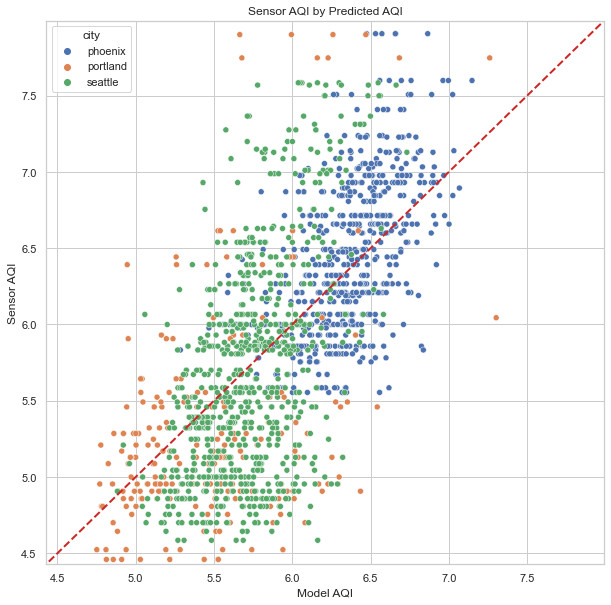

In [59]:
# Plots predictions by their true value
def plot_reference(y_pred, y_train, hue=None, draw_ref=True):
    # Draw reference lines
    if draw_ref:
        X = np.linspace(0, 240, 240)
        plt.plot(X, X, '--', color="#cc2727", linewidth=2)

    plot = sns.scatterplot(x=y_pred, y=y_train, hue=hue)

    # Set plot style
    max_lim = max(y_pred)
    min_lim = min(y_pred)
    max_lim += (max_lim-min_lim) / 10
    min_lim -= (max_lim-min_lim) / 10

    plot.set(ylim=(min_lim, max_lim))
    plot.set(xlim=(min_lim, max_lim))

    plot.set_title("Sensor AQI by Predicted AQI")
    plot.set_ylabel("Sensor AQI", fontsize = 12)
    plot.set_xlabel("Model AQI", fontsize = 12)

plot_reference(y_pred, y_train, hue=c_train)
#plot_reference(y_pred_test, y_test, hue=c_test)

## Experiment 2: Finding optimal vocab size

In [57]:
def test_vocab_knn(X_train, X_test, min_df, max_df, scores):
    # min_df sets the min document frequency for accepted words
    tf_vect = TfidfVectorizer(min_df=min_df, max_df=max_df).fit(X_train)
    words = tf_vect.get_feature_names_out()
    X_train_enc = tf_vect.transform(X_train)
    X_test_enc = tf_vect.transform(X_test)
    y_train = train_df['AQI'].apply(np.log2)
    y_test = test_df['AQI'].apply(np.log2)

    # Fit Regression model
    knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1).fit(X_train_enc, y_train)

    scores.append((knn_model.score(X_train_enc, y_train), knn_model.score(X_test_enc, y_test), len(words)))
    return


In [58]:
min_inc = min_df // 4
max_inc = max_df // 8
scores = []
for lo_df in range(min_df - min_inc * 2, min_df + min_inc * 2, min_inc):
   for hi_df in range(max_df - max_inc * 2, max_df + max_inc * 2, max_inc):
      test_vocab_knn(X_train, X_test, lo_df, hi_df, scores)

scores

[(0.4803405684388409, -1.3310793245658554),
 (0.4803405684388409, -1.3310793245658554),
 (0.4803405684388409, -1.3310793245658554),
 (0.4803405684388409, -1.3310793245658554),
 (0.4886133890743686, -1.313824921270513),
 (0.4886133890743686, -1.313824921270513),
 (0.4886133890743686, -1.313824921270513),
 (0.4886133890743686, -1.313824921270513),
 (0.49068399040484767, -1.4057341605604803),
 (0.49068399040484767, -1.4057341605604803),
 (0.49068399040484767, -1.4057341605604803),
 (0.49068399040484767, -1.4057341605604803),
 (0.4968102598501698, -1.4226519941766647),
 (0.4968102598501698, -1.4226519941766647),
 (0.4968102598501698, -1.4226519941766647),
 (0.4968102598501698, -1.4226519941766647)]

## Experiment 3: Random Forest for word importance extraction

In [52]:
from sklearn.ensemble import RandomForestRegressor

tree_model = RandomForestRegressor(random_state=23, n_estimators=20).fit(X_train_enc, y_train)

KeyboardInterrupt: 

In [ ]:
tree_model.score(X_train_enc, y_train), tree_model.score(X_test_enc, y_test)

(-1.2985493966227906, -1.0557215912298288)

In [ ]:
for idx in np.argpartition(tree_model.feature_importances_, -75)[-75:]:
    print(words[idx])

braj
crazyrichasians
langver
comicsgate
absentia
castrothoughts
chromedevsummit
valentines
trumpisadisgrace
bhole
ceebs
draenei
oitnb
stinky
arizonans
seattlesmoke
asbestos
gossiping
bxv
purifiers
ammo
kountz
romaine
sorrytobotheryou
pearljam
kus
bong13
casa
timeus
purifier
realdonaldtrump
santacon
badbunny
rackets
flyeaglesfly
heynow
katic
gardnerminshew
rwc7s
safeco
lasagna
gcu
10300
machina
livermtg18
pwa
marotta
screamlouder
khashoggi
n95
lilluh
aqi
mcsally
octiv
monoxide
edwindiaz
pullman
csl
monsoon
heeey
futurecast
uranium
osl
smoky
campfire
zunino
sedona
lowertheflag
kaveman
lmt
peoria
ilburn
generationdbacks
maricopa
talenti
